In [55]:
from rdflib import Graph, Namespace, RDF

def ttl_corpora_tags(filename:str) -> list[dict]:
    g = Graph()
    g.parse(filename, format="turtle")

    NIF = Namespace("http://persistence.uni-leipzig.org/nlp2rdf/ontologies/nif-core#")
    ITSRDF = Namespace("http://www.w3.org/2005/11/its/rdf#")

    data = []

    for context in g.subjects(RDF.type, NIF.Context):
        entry = {"corpus": None, "tags": []}

        for text in g.objects(context, NIF.isString):
            entry["corpus"] = str(text)

        for span in g.subjects(NIF.referenceContext, context):
            tag = {}

            for anchor in g.objects(span, NIF.anchorOf):
                tag["text"] = str(anchor)

            for begin in g.objects(span, NIF.beginIndex):
                tag["beginIndex"] = int(begin)
            for end in g.objects(span, NIF.endIndex):
                tag["endIndex"] = int(end)

            for ref in g.objects(span, ITSRDF.taIdentRef):
                tag["uri"] = str(ref)

            if tag:
                entry["tags"].append(tag)

        data.append(entry)
    return data

In [56]:
import matplotlib.pyplot as plt
from collections import Counter
import statistics
import json

def eda_file(filename):
    print(f"EDA {filename}\n--------------------------------")
    tags = ttl_corpora_tags(filename)
    print(f"The dataset contains {len(tags)} text fragments.\n")
    
    charlens = [len(t['corpus']) for t in tags]
    print(f"Character count per fragment (avg(min, max)): "
          f"{statistics.mean(charlens):.1f} ({min(charlens)}, {max(charlens)})")
    
    wordlens = [len(t['corpus'].split()) for t in tags]
    
    print(f"Word count in text fragments (avg(min, max)): {statistics.mean(wordlens)}({min(wordlens)}, {max(wordlens)})")
    
    plt.hist(wordlens)
    plt.title("Word count in text fragments")
    plt.show()

    tag_ents = Counter()
    for t in tags:
        tag_ents += Counter([te["uri"] for te in t['tags']])
        
    tag_ent_lens = [len(t['tags']) for t in tags]
    
    most_common_tags = dict(sorted(tag_ents.items(), key=lambda e: e[1], reverse=True)[:5])
    
    print(f"Tagged entity count in text fragments (avg(min, max)): {statistics.mean(tag_ent_lens)}({min(tag_ent_lens)}, {max(tag_ent_lens)})")
    
    plt.hist(tag_ent_lens)
    plt.title("Tagged entity count in text fragments")
    plt.show()
    
    print(f"Total unique tagged entities: {len(tag_ents)}")
    print(f"5 most commonly tagged:\n{json.dumps(most_common_tags,indent=4)}")

EDA ./N3/RSS-500.ttl
--------------------------------
The dataset contains 500 text fragments.

Character count per fragment (avg(min, max)): 170.9 (24, 1000)
Word count in text fragments (avg(min, max)): 31.008(6, 184)


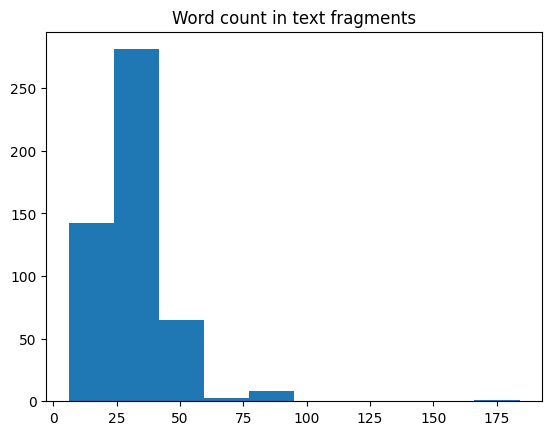

Tagged entity count in text fragments (avg(min, max)): 2(2, 2)


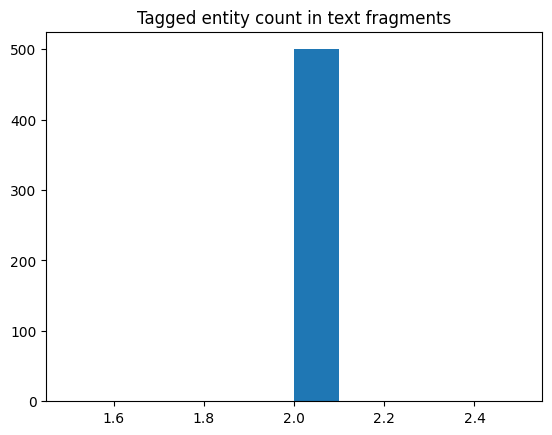

Total unique tagged entities: 849
5 most commonly tagged:
{
    "http://dbpedia.org/resource/Associated_Press": 11,
    "http://dbpedia.org/resource/Boston_Red_Sox": 6,
    "http://dbpedia.org/resource/Seattle_Mariners": 6,
    "http://dbpedia.org/resource/England_cricket_team": 5,
    "http://dbpedia.org/resource/Andrew_Strauss": 5
}



EDA ./N3/Reuters-128.ttl
--------------------------------
The dataset contains 128 text fragments.

Character count per fragment (avg(min, max)): 752.4 (106, 5148)
Word count in text fragments (avg(min, max)): 123.765625(18, 816)


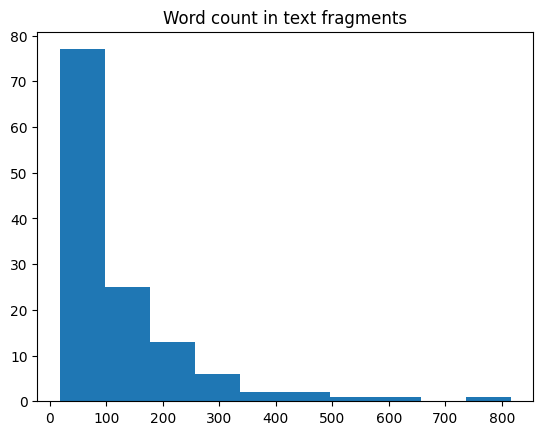

Tagged entity count in text fragments (avg(min, max)): 6.875(1, 43)


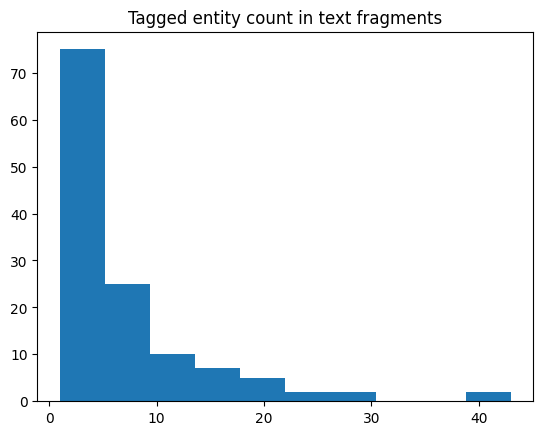

Total unique tagged entities: 444
5 most commonly tagged:
{
    "http://dbpedia.org/resource/Dominion_Textile": 15,
    "http://dbpedia.org/resource/Japan": 12,
    "http://dbpedia.org/resource/U.S._Securities_and_Exchange_Commission": 11,
    "http://dbpedia.org/resource/Burlington_Industries": 11,
    "http://dbpedia.org/resource/Reuter": 11
}





In [57]:
for file in ["./N3/RSS-500.ttl", "./N3/Reuters-128.ttl"]:
    eda_file(file)
    print("\n\n")